In [85]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from collections import Counter
import numpy as np
import numpy.linalg as LA
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#import geoplot as gplt
import glob
import datetime as dt
import random
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
import time
from locale import atof, setlocale, LC_ALL
import warnings
from scipy.stats import percentileofscore
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display

NOTEBOOK_VERSION = 1.0

In [86]:
class flussi():
    impianti_file = 'impianti.csv'
    impianti_df = pd.read_csv(impianti_file).drop('Note', axis = 1)

    codice_set = list(set(impianti_df['Codice']))
    nome_set = list(set(impianti_df['Nome']))

    geo_start = gpd.points_from_xy(impianti_df['Latitude Start'], impianti_df['Longitude Start'])
    geo_end = gpd.points_from_xy(impianti_df['Latitude Start'], impianti_df['Longitude Start'])
    
    impianti_df = gpd.GeoDataFrame(impianti_df)

    impianti_df['GEO_START'] = geo_start
    impianti_df['GEO_END'] = geo_end
    
    impianto_line = gpd.GeoSeries(impianti_df.apply(lambda row: LineString([row['GEO_START'], row['GEO_END']]), axis=1))
    impianti_df['IMPIANTO_LINE'] = impianto_line

    
    def __init__(self, input_file, fast = False):
        '''Carica il file dei dati ed estrae le quantita di interesse'''
        self.file_name = input_file.split('/')[-1][0:-4]
        self.impianti = self.file_name[11:]
        self.date = self.file_name[0:10]
        self.year = int(self.date[-4:])
        self.month = int(self.date[3:5])
        self.day = int(self.date[:2])
        
        if VERBOSE > 0:
            print('starting read_csv')
        try:
            self.df = pd.read_csv(input_file)
        except:
            try:
                self.df = pd.read_excel(input_file)
                print(set(self.df['IMPIANTO']))
                self.df.rename({'IMPIANTO':'ID_IMPIANTO'}, axis = 1, inplace = True)
            except:
                print(Exception('Input must be csv or Excel file.'))
        if VERBOSE > 0:
            print('finished read_csv')

        self.df['DATA_ORA'] = pd.to_datetime(self.df['DATA_ORA'], format = "%d/%m/%Y %H.%M.%S")
            
        self.N = len(self.df)
        
        self.df = pd.merge(self.df, flussi.impianti_df, left_on = 'ID_IMPIANTO', right_on = 'Codice')
        
        if VERBOSE > 0:
            print('finished added lift names')

        geo_start = gpd.points_from_xy(self.df['Latitude Start'], self.df['Longitude Start'])
        geo_end = gpd.points_from_xy(self.df['Latitude End'], self.df['Longitude End'])
        self.df = gpd.GeoDataFrame(self.df)
        self.df['GEO START'] = geo_start
        self.df['GEO END'] = geo_end

        if VERBOSE > 0:
            print('finished adding geodata')
        
        if VERBOSE>2:
            print(f'\n Caricato: {self.file_name}. Esempio record prima risalita:')
            print(self.df.loc[0])
        
        self.cassa = self.df['CASSA']
        self.cassa_set = list(set(self.cassa))
        self.N_casse = len(self.cassa_set)
        self.cassa_counter = Counter(self.cassa)

        if VERBOSE > 0:
            print('finished cassa')
        
        # la serie e' la ID dello sciatore
        self.serie = self.df['SERIE']
        self.serie_set = list(set(self.serie))
        self.serie_counter = Counter(self.serie)

        if VERBOSE > 0:
            print('finished serie')

        self.df['SKIER_ID'] = self.df['SERIE']*1000 + self.df['CASSA']
        self.skier_id = self.df['SKIER_ID'] 
        self.skier_id_set = list(set(self.skier_id))
        self.skier_id_counter = Counter(self.skier_id)
        self.N_sciatori = len(self.skier_id_set)


        if VERBOSE > 0:
            print('finished skier_id')

        self.data_ora = self.df['DATA_ORA']
        self.data_ora_set = list(set(self.data_ora))

        if VERBOSE > 0:
            print('finished data_ora')

        if not fast:
            self.pool = self.df['POOL']
            self.pool_set = list(set(self.pool))

        if VERBOSE > 0:
            print('finished pool')

        self.impianto = self.df['ID_IMPIANTO']
        self.impianto_set = list(set(self.impianto))
        self.N_impianti = len(self.impianto_set)
        self.impianto_counter = Counter(self.impianto)

        if VERBOSE > 0:
            print('finished id_impianto')


        try:
            self.lettore = self.df['ID_LETTORE']
            self.lettore_set = list(set(self.lettore))
        except:
            print(f'No column ID_LETTORE for file {input_file}')

        if VERBOSE > 0:
            print('finished id_lettore')
        
        if not fast:
            self.flow_matrix, self.flow_matrices, self.skier_num_runs = self.get_flow_matrix()
            self.diff_matrix = self.get_skier_diff()

        if VERBOSE > 0:
            print('finished flow and diff mats')
        
        if VERBOSE>1:
            print(f'Sommario {self.file_name} -- {self.N} risalite per {self.N_sciatori} sciatori su {self.N_impianti} impianti di risalita.')

        if VERBOSE > 0:
            print('finished constructor')
        
    def show_stats(self):
        '''Show some basic statistics of the data'''
        
        ## Contare le risalite per sciatore
        corse = np.zeros((self.N_sciatori))
        for i in range(self.N_sciatori):
            corse[i] = self.serie_counter[self.serie_set[i]]
    
        corse = np.flip(np.sort(corse))
        
        
        plt.subplot(1,2,1)
        plt.plot(range(1,self.N_sciatori+1), corse,lw=3,label=self.date)
        plt.xscale('log')
        
        plt.title(f'Risalite per sciatore - {self.impianti}',fontsize=24)
        plt.xlabel('Indice sciatore',fontsize=20)
        plt.ylabel('Numero risalite',fontsize=20)
        
        ## Contare le risalite per impianto
        corse = np.zeros((self.N_impianti))
        for i in range(self.N_impianti):
            corse[i] = self.impianto_counter[self.impianto_set[i]]
    
        corse = np.flip(np.sort(corse))
        
        # plotta le risalite per impianto
        plt.subplot(1,2,2)
        plt.plot(corse,lw=3,label=self.date)
        
        plt.title(f'Risalite per impianto - {self.impianti}',fontsize=24)
        plt.xlabel('Indice impianto',fontsize=20)
        plt.ylabel('Numero risalite',fontsize=20)
        
    def create_sample(self, size):
        return flussi('./file csv/'+self.file_name+'.txt', size)
    
    def build_flow_init(self):
        df = self.df
        zer = np.zeros((len(self.impianto_set),len(self.impianto_set)))
        flow_matrix = pd.DataFrame(data = zer, columns = self.impianto_set)
        flow_matrix['ind'] = self.impianto_set
        flow_matrix.set_index('ind', inplace = True, drop = True)
        return flow_matrix

    def get_flow_matrix(self, num_skiers = None):
        if num_skiers:
            skier_id_sample = random.sample(self.skier_id_set, num_skiers)
        else:
            skier_id_sample = self.skier_id_set
            
        
        if VERBOSE > 0:
            print('finished sample')

        df = self.dfa
        flow_matrix = self.build_flow_init()
        flow_matrices={}
        skier_num_runs={}

        if VERBOSE > 0:
            print('finished builidng df and dicts')
        
        if VERBOSE > 0:
            k=0
        # loop over each skier
        for s in skier_id_sample:

            # select the sequence of rides for skier s sorted by time
            ski_day = df[df['SKIER_ID'] == s].sort_values('DATA_ORA')
            skier_num_runs[s] = len(ski_day)
            current_fm = self.build_flow_init()
            flow_matrices[s] = current_fm

            for i in range(len(ski_day) - 1):
                x = ski_day['ID_IMPIANTO'].iloc[i]
                y = ski_day['ID_IMPIANTO'].iloc[i+1]
                flow_matrix[y][x]+=1
                current_fm[y][x]+=1

            if VERBOSE > 0:
                k+=1
                if k % 1000 == 0:
                    print(f'loop {k}/{len(skier_id_sample)}')

        return flow_matrix, flow_matrices, skier_num_runs

    def get_skier_diff(self, num_skiers = None, log = False, flow_matrices = None, skier_num_runs = None): #consider adding paramter for log base

        '''
        returns matrix of differences between skiers
        difference is given by distance between unrolled flow matrices of any two skiers
        first tries to use flow_matrices given by parameter, which do not exist when FAST = True, then tries using flow_matrices passed as arg,
        then calculates from get_flow_matrix
        log = True takes log2 of unrolled flow matrix before finding distance.
        '''

        try:
            flow_matrices = self.flow_matrices
            skier_num_runs = self.skier_num_runs
        except:
            if not flow_matrices or not skier_num_runs:
                flow_matrix, flow_matrices, skier_num_runs = self.get_flow_matrix(num_skiers=num_skiers)

        

        if num_skiers:
            skier_id_sample = random.sample(list(skier_num_runs.keys()), num_skiers)
        else:
            skier_id_sample = list(skier_num_runs.keys())
        
        
        zer = np.zeros((len(skier_id_sample),len(skier_id_sample)))
        diff_matrix = pd.DataFrame(data = zer, columns = skier_id_sample)
        diff_matrix['ind'] = list(skier_id_sample)
        diff_matrix.set_index('ind', inplace = True, drop = True)
        
        k=1
        for i in skier_id_sample:
            for j in skier_id_sample[k:]:

                if log:
                    a_log = np.log2(flow_matrices[i].to_numpy()+1)
                    b_log = np.log2(flow_matrices[j].to_numpy()+1)
                    diff_matrix[j][i] = LA.norm(a_log - b_log)
                    diff_matrix[i][j] = LA.norm(a_log - b_log)
                else:
                    a = flow_matrices[i].to_numpy()
                    b = flow_matrices[j].to_numpy()
                    diff_matrix[j][i] = LA.norm(a - b)
                    diff_matrix[i][j] = LA.norm(a - b)

            k+=1
        return diff_matrix

    def get_ski_day(self, id):
        return self.df[self.skier_id == id].sort_values('DATA_ORA')
    

In [87]:
INPUT_DIR = './file csv/'
FILE_STRINGS = ['2006-SelvaColfosco','2006-Selva']
VERBOSE = 0
FAST = True

k=0
dataset_list = []
for str in FILE_STRINGS: ## each str is a group of files

    INPUT_FILES = glob.glob(INPUT_DIR + f'*{str}.txt') # group of files chosen by str

    if not FAST:
        fig = plt.figure(figsize=(20,10))
   
    for f in INPUT_FILES:
        fl = flussi(f, fast = FAST)
        if not FAST:
            fl.show_stats()
        dataset_list.append(fl)
    
    if not FAST:
        for i in range(1,3):
            plt.subplot(1,2,i)
            plt.legend(fontsize=18)

In [88]:
dataset_list[0].df

,CASSA,SERIE,DATA_ORA,POOL,ID_IMPIANTO,ID_LETTORE,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE,GEO START,GEO END,SKIER_ID
0,346,63173,2006-01-05 08:36:00,1,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),63173346
1,72,18484,2006-01-05 08:36:00,311,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),18484072
2,74,50143,2006-01-05 08:42:00,314,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),50143074
3,74,50145,2006-01-05 08:42:00,314,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),50145074
4,74,50147,2006-01-05 08:42:00,314,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),50147074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97850,98,17654,2006-01-05 16:30:00,1,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),17654098
97851,179,32220,2006-01-05 16:31:00,126,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),32220179
97852,100,23022,2006-01-05 16:31:00,1,392,2,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),23022100
97853,100,23274,2006-01-05 16:32:00,314,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739),23274100


In [89]:
flussi.impianti_df

,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE
0,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)"
1,176,Borest Rit,46.549766,11.857081,46.548524,11.870785,"1,056.27",POINT (46.54977 11.85708),POINT (46.54977 11.85708),"LINESTRING (46.54977 11.85708, 46.54977 11.85708)"
2,177,Sodlisia,46.549922,11.855720,46.550120,11.845326,794.54,POINT (46.54992 11.85572),POINT (46.54992 11.85572),"LINESTRING (46.54992 11.85572, 46.54992 11.85572)"
3,180,Plans,46.547991,11.843061,46.555936,11.812015,"2,531.18",POINT (46.54799 11.84306),POINT (46.54799 11.84306),"LINESTRING (46.54799 11.84306, 46.54799 11.84306)"
4,182,Frara,46.548174,11.827447,46.555936,11.812015,"1,460.90",POINT (46.54817 11.82745),POINT (46.54817 11.82745),"LINESTRING (46.54817 11.82745, 46.54817 11.82745)"
5,186,Colfosco,46.550314,11.853338,46.562385,11.850872,"1,354.38",POINT (46.55031 11.85334),POINT (46.55031 11.85334),"LINESTRING (46.55031 11.85334, 46.55031 11.85334)"
6,220,Ciampinoi,46.553097,11.761725,46.538755,11.753416,"1,715.42",POINT (46.55310 11.76172),POINT (46.55310 11.76172),"LINESTRING (46.55310 11.76172, 46.55310 11.76172)"
7,221,Dantercepies,46.555676,11.767955,46.553689,11.799795,"2,442.85",POINT (46.55568 11.76795),POINT (46.55568 11.76795),"LINESTRING (46.55568 11.76795, 46.55568 11.76795)"
8,222,Costabella,46.552438,11.764028,46.552505,11.769349,406.68,POINT (46.55244 11.76403),POINT (46.55244 11.76403),"LINESTRING (46.55244 11.76403, 46.55244 11.76403)"
9,225,Larciunei,46.557724,11.763794,46.556665,11.766544,240.75,POINT (46.55772 11.76379),POINT (46.55772 11.76379),"LINESTRING (46.55772 11.76379, 46.55772 11.76379)"


In [22]:
class plot_manager():
    '''
    FROM PIETRO PERONA
    '''    
    def __init__(self):
         # set up PDF file to save plots
        date_time = dt.datetime.today().strftime('%Y-%m-%d--%H:%M')
        self.OUT_PDF_FILE_NAME = f'./plots--{date_time}.pdf'
        self.figList = [] # clear list of figures
        print(f'Plots will be saved in {self.OUT_PDF_FILE_NAME}')
    
    
    def startPDFReport(self):
        '''titleScreen: Displays a few stats of the dataset on a title screen for the PDF report'''
        
        LINE_SPACING = 1
        
        # initialize the output file pointer and the list of figures
        self.outPDF = PdfPages(self.OUT_PDF_FILE_NAME)
        
        # set up figure that will be used to display the opening banner
        fig = plt.figure(figsize=(20,5*LINE_SPACING))
        plt.axis('off')
        
        # stuff to be printed out on the first page of the report
        plt.text(0,1*LINE_SPACING,f'Data files series={FILE_STRINGS}',fontsize=24)
        plt.text(0,2*LINE_SPACING,f'Date of analysis: {str(dt.datetime.now())}',fontsize=24)
        plt.text(0,3*LINE_SPACING,f'Jupyter Notebook version: {NOTEBOOK_VERSION}',fontsize=24)
        plt.ylim([-1, 4*LINE_SPACING])
        plt.gca().invert_yaxis()
        
        self.figList = [] # clear list of figures
        self.figList.append(fig)
    
    
    def endPDFReport(self):
        '''endReport: Writes figures to PDF file and closes it.'''
        for fig in self.figList:
            self.outPDF.savefig(fig)
            plt.close(fig) # this will prevent the figures from being shown in Pyplot and will save them to PDF instead
        self.outPDF.close()
        self.figList = [] # clear list of figures

In [ ]:
# DEPRECATED, INCLUDED IN FLUSSO CLASS
'''def build_flow_init(flusso):
    df = flusso.df
    zer = np.zeros((len(flusso.impianto_set),len(flusso.impianto_set)))
    flow_matrix = pd.DataFrame(data = zer, columns = flusso.impianto_set)
    flow_matrix['ind'] = flusso.impianto_set
    flow_matrix.set_index('ind', inplace = True, drop = True)
    return flow_matrix

def get_flow_matrix(flusso, num_skiers = None):
    if num_skiers:
        skier_id_sample = random.sample(flusso.skier_id_set, num_skiers)
    else:
        skier_id_sample = flusso.skier_id_set
    
    df = flusso.df
    flow_matrix = build_flow_init(flusso)
    flow_matrices={}
    skier_num_runs={}
    
    print(flusso.N)
    
    # loop over each skier
    for s in skier_id_sample:
        
        # select the sequence of rides for skier s sorted by time
        ski_day = df[df['SKIER_ID'] == s].sort_values('DATA_ORA')
        skier_num_runs[s] = len(ski_day)
        current_fm = build_flow_init(dataset_list[0])
        flow_matrices[s] = current_fm
    
        for i in range(len(ski_day) - 1):
            x = ski_day['ID_IMPIANTO'].iloc[i]
            y = ski_day['ID_IMPIANTO'].iloc[i+1]
            flow_matrix[y][x]+=1
            current_fm[y][x]+=1
            
    return flow_matrix, flow_matrices, skier_num_runs'''

In [ ]:
#DEPRECATED, INCLUDED IN FLUSSO CLASS
'''def get_skier_diff(flusso, num_skiers = None):
    #flow_matrix = flusso.flow_matrix
    flow_matrices = flusso.flow_matrices
    skier_num_runs = flusso.skier_num_runs

    if num_skiers:
        skier_id_sample = random.sample(list(flusso.skier_num_runs.keys()), num_skiers)
    else:
        skier_id_sample = list(flusso.skier_num_runs.keys())
    
    #df = flusso.df
    
    zer = np.zeros((len(serie_sample),len(serie_sample)))
    diff_matrix = pd.DataFrame(data = zer, columns = serie_sample)
    diff_matrix['ind'] = list(serie_sample)
    diff_matrix.set_index('ind', inplace = True, drop = True)
    
    k=1
    for i in serie_sample:
        for j in serie_sample[k:]:
            #dist = LA.norm(flow_matrices[i] - flow_matrices[j])
            #diff_runs = np.abs(skier_num_runs[i] - skier_num_runs[j])
            #num_runs = skier_num_runs[i] + skier_num_runs[j]
            #diff_matrix[j][i] = (dist + (1/num_runs)) / (num_runs/2)
            i_log = np.log2(flow_matrices[i].to_numpy()+1)
            j_log = np.log2(flow_matrices[j].to_numpy()+1)
            diff_matrix[j][i] = LA.norm(i_log - j_log)
            diff_matrix[i][j] = LA.norm(i_log - j_log)
        #print(k,'/',len(serie_sample))
        k+=1
    return diff_matrix'''

In [8]:
VERBOSE = 0
flusso = dataset_list[5]
flusso.flow_matrix, flusso.flow_matrices, flusso.skier_num_runs = flusso.get_flow_matrix()
print(flusso.day, flusso.month)

1 3


In [134]:
flusso.flow_matrix

,225,227,228,232,233,234,392,175,177,180,182,186,220,221,222
ind,,,,,,,,,,,,,,,
225,2320.0,206.0,1435.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,163.0,297.0,5.0
227,270.0,1802.0,383.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1115.0,799.0,47.0
228,686.0,446.0,6500.0,0.0,1.0,2.0,930.0,1.0,2.0,2.0,0.0,4.0,292.0,1023.0,33.0
232,120.0,585.0,266.0,148.0,21.0,331.0,459.0,29.0,10.0,27.0,10.0,58.0,4441.0,998.0,92.0
233,0.0,1.0,0.0,8191.0,29.0,1.0,0.0,16.0,9.0,53.0,41.0,123.0,1.0,0.0,0.0
234,78.0,72.0,283.0,2.0,0.0,2067.0,0.0,0.0,0.0,0.0,0.0,3.0,161.0,414.0,7.0
392,98.0,99.0,480.0,0.0,0.0,2.0,916.0,1.0,0.0,3.0,0.0,0.0,330.0,612.0,18.0
175,1.0,0.0,0.0,2.0,0.0,0.0,1.0,24.0,10745.0,15.0,0.0,416.0,1.0,0.0,0.0
177,0.0,0.0,0.0,6.0,18.0,0.0,2.0,154.0,492.0,9607.0,0.0,3176.0,0.0,2.0,17.0


In [132]:
flusso.flow_matrix.sum(axis = 1)

ind
225     4429.0
227     4421.0
228     9922.0
232     7595.0
233     8465.0
234     3087.0
392     2559.0
175    11205.0
177    13474.0
180    10324.0
182      351.0
186     4456.0
220     5455.0
221     9559.0
222     8897.0
dtype: float64

In [124]:
flusso.df[flusso.df['SKIER_ID'] == flusso.skier_id_set[1]].sort_values('DATA_ORA')

,CASSA,SERIE,DATA_ORA,POOL,ID_IMPIANTO,ID_LETTORE,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE,GEO START,GEO END,SKIER_ID
3744,145,65798,2006-03-01 11:35:00,1,175,4,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708),65798145
16550,145,65798,2006-03-01 11:43:00,1,177,3,177,Sodlisia,46.549922,11.855720,46.550120,11.845326,794.54,POINT (46.54992 11.85572),POINT (46.54992 11.85572),"LINESTRING (46.54992 11.85572, 46.54992 11.85572)",POINT (46.54992 11.85572),POINT (46.55012 11.84533),65798145
30030,145,65798,2006-03-01 11:51:00,1,180,4,180,Plans,46.547991,11.843061,46.555936,11.812015,"2,531.18",POINT (46.54799 11.84306),POINT (46.54799 11.84306),"LINESTRING (46.54799 11.84306, 46.54799 11.84306)",POINT (46.54799 11.84306),POINT (46.55594 11.81201),65798145
117419,145,65798,2006-03-01 12:06:00,1,233,3,233,Val Setus,46.552315,11.809052,46.554178,11.804831,383.29,POINT (46.55232 11.80905),POINT (46.55232 11.80905),"LINESTRING (46.55232 11.80905, 46.55232 11.80905)",POINT (46.55232 11.80905),POINT (46.55418 11.80483),65798145
108036,145,65798,2006-03-01 12:14:00,1,232,3,232,Cir,46.550132,11.806569,46.554219,11.800127,657.79,POINT (46.55013 11.80657),POINT (46.55013 11.80657),"LINESTRING (46.55013 11.80657, 46.55013 11.80657)",POINT (46.55013 11.80657),POINT (46.55422 11.80013),65798145
54728,145,65798,2006-03-01 13:29:00,1,220,1,220,Ciampinoi,46.553097,11.761725,46.538755,11.753416,"1,715.42",POINT (46.55310 11.76172),POINT (46.55310 11.76172),"LINESTRING (46.55310 11.76172, 46.55310 11.76172)",POINT (46.55310 11.76172),POINT (46.53876 11.75342),65798145


In [110]:
dist_df = flusso.get_skier_diff(400, log = True)
dist_df

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

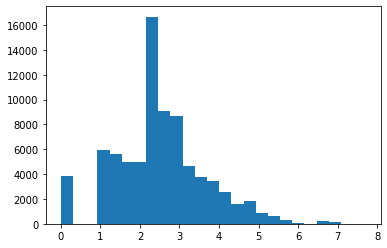

In [93]:
dist_mat = dist_df.to_numpy()
dist_arr = np.array([])
for i in range(len(dist_mat)):
    for j in range(i+1,len(dist_mat)):
        dist_arr = np.append(dist_arr, dist_mat[i][j])
plt.hist(dist_arr, bins = 25)
plt.show

In [94]:
X = np.empty((0,flusso.N_impianti**2), int)
X_log = np.empty((0,flusso.N_impianti**2), int)
X_norm = np.empty((0,flusso.N_impianti**2), int)
for skier_id in flusso.skier_id_set:
    fm_unrolled = flusso.flow_matrices[skier_id].to_numpy().ravel()
    X = np.append(X, [fm_unrolled], axis = 0)
    X_log = np.append(X_log, [np.log(fm_unrolled+1)], axis = 0)
    X_norm = np.append(X_norm, [fm_unrolled/np.max(fm_unrolled)], axis = 0)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_51290/1469418689.py:8: RuntimeWarning: invalid value encountered in true_divide
  X_norm = np.append(X_norm, [fm_unrolled/np.max(fm_unrolled)], axis = 0)


KeyboardInterrupt: 

In [104]:
X[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [ ]:
U,s,VT=LA.svd(X)
U_log,s_log,VT_log = LA.svd(X_log)

In [95]:
N_CLUSTERS = 12
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(X)
kmeans_log = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(X_log)
#kmeans_norm = KMeans(n_clusters=12, random_state=0).fit(X_norm)
centroids = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans.cluster_centers_]
centroids_log = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans_log.cluster_centers_]
#centroids_norm = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans_norm.cluster_centers_]

In [96]:
def centroids_as_flow_mat(cent_list):
    flow_mat_list = []
    for c in cent_list:
        c_trunc = np.trunc(c*10)/10
        c_flow_matrix = pd.DataFrame(data = c_trunc, columns = flusso.impianto_set)
        c_flow_matrix['ind'] = flusso.impianto_set #flusso needs to be parameterized
        c_flow_matrix.set_index('ind', inplace = True, drop = True)
        flow_mat_list.append(c_flow_matrix)
    return flow_mat_list

In [97]:
SAMPLE_SIZE = flusso.N_sciatori

x = [np.dot(x_i, VT[0]) for x_i in X]
y = [np.dot(x_i, VT[1]) for x_i in X]

x_log = [np.dot(x_i, VT[0]) for x_i in X_log]
y_log = [np.dot(x_i, VT[1]) for x_i in X_log]

plt.subplot(1,2,1)
plt.scatter(x = random.sample(x,SAMPLE_SIZE), y = random.sample(y,SAMPLE_SIZE))
for c in centroids:
    plt.scatter( np.dot(c.ravel(), VT[0]), np.dot(c.ravel(), VT[1]), c = 'r')

plt.subplot(1,2,2)
plt.scatter(x = random.sample(x_log,SAMPLE_SIZE), y = random.sample(y_log,SAMPLE_SIZE))
for c in centroids_log:
    plt.scatter( np.dot(c.ravel(), VT_log[0]), np.dot(c.ravel(), VT_log[1]), c = 'r')

plt.show()

NameError: name 'VT' is not defined

In [98]:
def plot_impianti(ax = None):
    for row in flussi.impianti_df.iterrows():
        lat_start  = row[1]['Latitude Start']
        long_start = row[1]['Longitude Start']
        lat_end    = row[1]['Latitude End']
        long_end   = row[1]['Longitude End']
        
        mid_lat = np.mean([lat_start, lat_end])
        mid_long = np.mean([long_start, long_end])
        
        geometry = LineString([(long_start, lat_start),(long_end, lat_end)])
        gdf = gpd.GeoDataFrame(geometry=[geometry])
        ax = gdf.plot(ax = ax, lw = 2.5, color='k')
        #ax = gdf.plot(lw = 2.5, color='k')
        ax.text(s=row[1]['Nome'],x = mid_long, y = mid_lat)
    return ax

def plot_flow_matrix(flow_matrix, kmeans = None, ax = None, cent_i = None, pre_plot_impianti = None):
    max_flow = flow_matrix.max().max()
    
    if pre_plot_impianti:
        ax = pre_plot_impianti
    else:
        ax = plot_impianti(ax)
    idf = flussi.impianti_df

    THRESH = 0.0
    THICKNESS_FACTOR = 10
    geometry = np.empty((len(flow_matrix)**2,), np.dtype(LineString))
    thickness = np.zeros(len(flow_matrix)**2)
    lw = np.empty((len(flow_matrix)**2,), np.dtype(LineString))

    k = 0

    for i in flow_matrix:
        for j in flow_matrix:
            if flow_matrix[i][j]/max_flow < THRESH:
                continue

            row_i = idf[idf['Codice'] == i]
            row_j = idf[idf['Codice'] == j]

            lat_start  = float(row_i['Latitude Start'])
            long_start = float(row_i['Longitude Start'])
            lat_end    = float(row_j['Latitude End'])
            long_end   = float(row_j['Longitude End'])
            
            geometry[k] = LineString([(long_start, lat_start),(long_end, lat_end)])
            thickness[k] = THICKNESS_FACTOR*flow_matrix[i][j]/max_flow
            k+=1

    gdf = gpd.GeoDataFrame(geometry=geometry)
    gdf['thickness'] = thickness
    ax = gdf.plot(ax = ax, lw = gdf['thickness'], color='r', alpha = 0.5) 
    
    if cent_i != None:
        n_in_cent = Counter(kmeans.labels_)[cent_i]
        ax.set_title(f'Plot {cent_i}: Max = {max_flow}, n = {n_in_cent}', fontsize = 18)
            
            
def plot_centroids(kmeans, centroids):
    len_cent = len(centroids)

    fig = plt.figure(figsize=(20,4*len_cent))
    gs = gridspec.GridSpec(ncols = 2, nrows = len_cent, width_ratios=(2,1))

    last_ax2 = None
    BINS = np.arange(-1,2,0.25)

    plot_impianti()

    for i, cent in enumerate(centroids):
        ax = fig.add_subplot(gs[2*i])

        plot_flow_matrix(cent, kmeans, ax, i)

        ax2 = fig.add_subplot(gs[2*i+1])
        
        dists = LA.norm(X[kmeans.labels_ == i] - kmeans.cluster_centers_[i], axis = 1)
        ax2.hist(np.log10(dists),bins=BINS)

        last_ax2 = ax2

    fig.suptitle('K-Means Centroids', fontsize = 28, y=0.9)
    plt.show()

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_51290/2643617700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if flow_matrix[i][j]/max_flow < THRESH:
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_51290/2643617700.py:49: RuntimeWarning: invalid value encountered in double_scalars
  thickness[k] = THICKNESS_FACTOR*flow_matrix[i][j]/max_flow
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_51290/2643617700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if flow_matrix[i][j]/max_flow < THRESH:
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_51290/2643617700.py:49: RuntimeWarning: invalid value encountered in double_scalars
  thickness[k] = THICKNESS_FACTOR*flow_matrix[i][j]/max_flow
/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_51290/2643617700.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if flow_matrix[i][j]/max_flow < THRESH:
/var/folders/21/flqpgr7x45s3tfyly7hcx

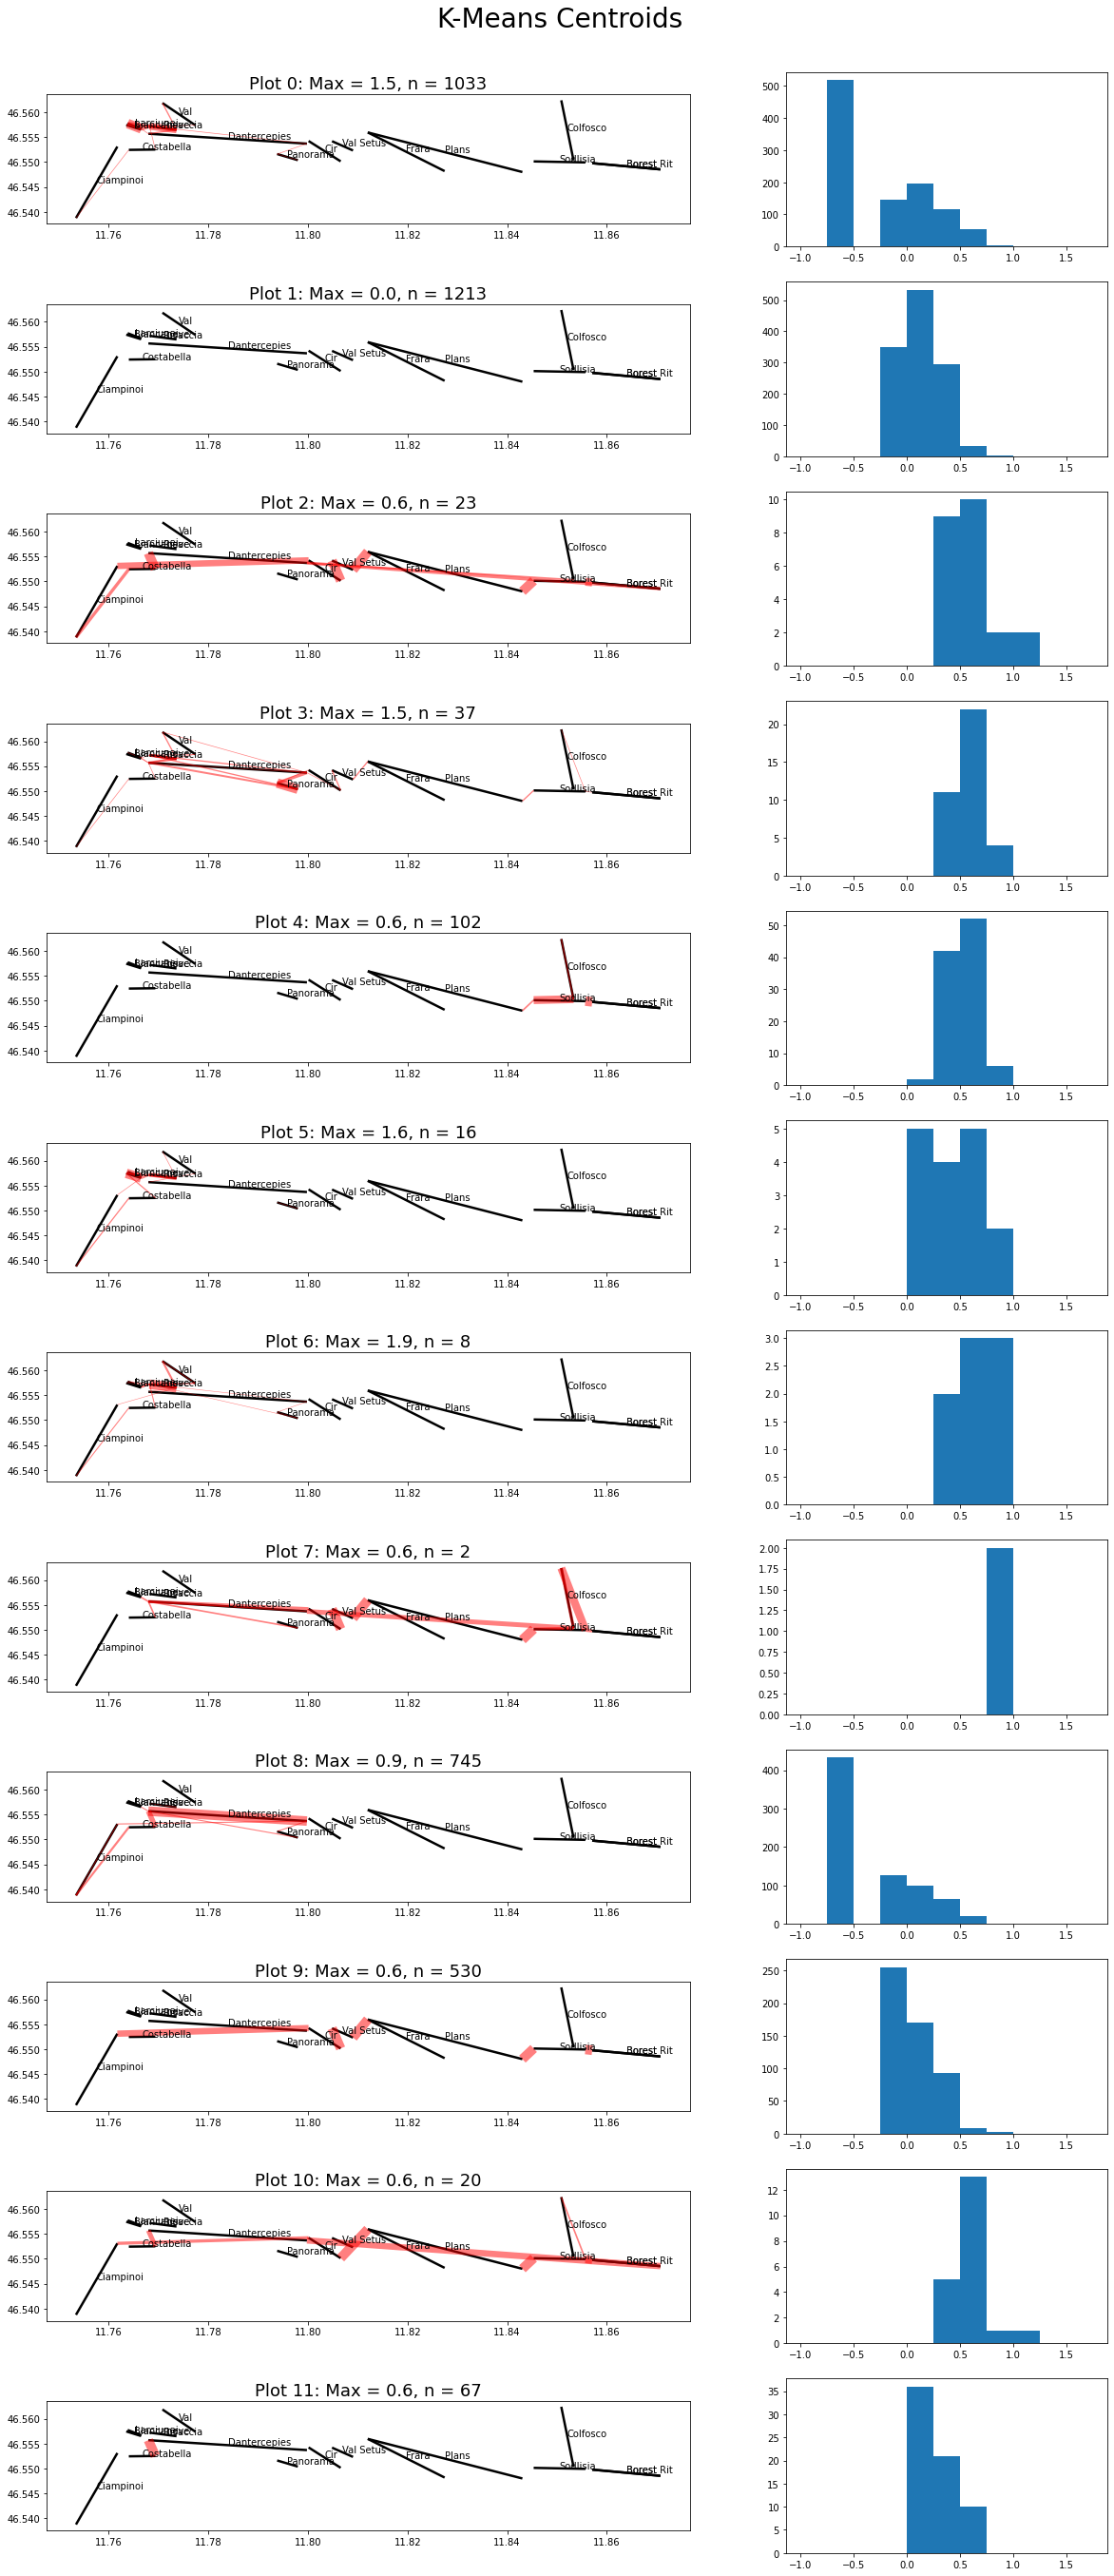

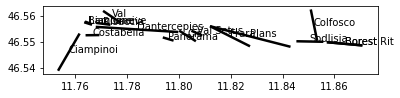

<Figure size 432x288 with 0 Axes>

In [109]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids_log))
plt.savefig('fsdfs')

In [ ]:
centroids_log.

In [101]:
centroids_as_flow_mat(centroids)[1]

,225,227,228,232,233,234,392,175,177,180,182,186,220,221,222
ind,,,,,,,,,,,,,,,
225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
232,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.1,0.0
233,0.0,0.0,0.0,0.9,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids_log))

In [ ]:
anti_01_03 = pd.read_excel('rasom_sella_ronda/SensoAntiorario-2006-01-03.xls')
anti_01_03_skier_id_set = list(set(anti_01_03['SKIER_ID']))
anti_01_03_skier_id_set

In [ ]:
print(flusso.file_name)

In [ ]:
len(flusso.df[flusso.df['SERIE'].isin(anti_01_03_serie_set)])

In [ ]:
len(flusso.df)

In [ ]:
set(anti_01_03['IMPIANTO'])

In [ ]:
fluss_anti_01_03 = flussi('rasom_sella_ronda/SensoAntiorario-2006-01-03.xls')

In [ ]:
print(fluss_anti_01_03.flow_matrix.max().max())
plot_flow_matrix(fluss_anti_01_03.flow_matrix)

In [105]:
for i in range(len(centroids)):
    kmeans_anti = np.array(list(flusso.flow_matrices.keys()))[kmeans.labels_ == i]
    kmeans_anti_in_giov_anti = [f for f in kmeans_anti if f in fluss_anti_01_03.serie_set]
    giov_anti_in_kmeans_anti = [f for f in fluss_anti_01_03.serie_set if f in kmeans_anti]
    print(i, len(kmeans_anti_in_giov_anti)/len(kmeans_anti), len(giov_anti_in_kmeans_anti)/len(fluss_anti_01_03.serie_set))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 24481 but corresponding boolean dimension is 3796

In [108]:
len(flusso.skier_id_set)

24481

In [ ]:
'''TIME_INTERVAL = 3600/2
START_TIME = 7
START_TIME_DT = dt.datetime(year = flusso.year, month = flusso.month, day = flusso.day, hour = START_TIME)
START_TIME_SECONDS = START_TIME*3600
END_TIME = 18
END_TIME_DT = dt.datetime(year = flusso.year, month = flusso.month, day = flusso.day, hour = END_TIME)
END_TIME_SECONDS = END_TIME*3600
MIDNIGHT = dt.datetime(year = flusso.year, month = flusso.month, day = flusso.day)
N = 1000#flusso.N_sciatori

times_df = pd.DataFrame(columns = np.arange(START_TIME, END_TIME, TIME_INTERVAL / 3600))

links_raw = {}
links = {}
links_norm = {}
throughput = {}
throughput_norm = {}

df_accesses = 0
new_dfs = 0
new_rows = 0
df_additions = 0

setlocale(LC_ALL, 'en_US.UTF-8')

for s in random.sample(flusso.skier_id_set, N):
    ski_day = flusso.df[flusso.df['SKIER_ID'] == s].sort_values('DATA_ORA')

    for i,row in enumerate(ski_day[:-1].iterrows()):
        start = time.time_ns()

        origin = ski_day.iloc[i]['ID_IMPIANTO']
        dest = ski_day.iloc[i+1]['ID_IMPIANTO']

        end = time.time_ns()
        df_accesses += end - start

        time_arrival = (ski_day.iloc[i+1]['DATA_ORA'] - MIDNIGHT).total_seconds()
        time_delt = (ski_day.iloc[i+1]['DATA_ORA'] - ski_day.iloc[i]['DATA_ORA']).total_seconds()
        

        len_imp_str = flussi.impianti_df['Length'][flussi.impianti_df['Codice'] == origin].iloc[0]
        len_imp = atof(len_imp_str)
        if time_delt < len_imp / 5:
            continue

        start = time.time_ns()

        if dest not in links_raw.keys():
            links_raw[dest] = pd.DataFrame(columns = np.arange(START_TIME, END_TIME, TIME_INTERVAL / 3600))
            throughput[dest] = np.zeros(int((END_TIME - START_TIME) * 3600/TIME_INTERVAL))

        end = time.time_ns()
        new_dfs += end - start
        
        start = time.time_ns()

        if origin not in links_raw[dest].index:
            df = links_raw[dest]
            empty_row = [np.array([]) for _ in df.columns]
            df.loc[origin] = empty_row
        
        end = time.time_ns()
        new_rows += end - start

        start = time.time_ns()
        
        col_iloc = int((time_arrival//TIME_INTERVAL) - (START_TIME*3600//TIME_INTERVAL))
        arr = links_raw[dest].loc[origin].iloc[col_iloc]
        arr = np.append(arr, time_delt)
        if len(arr) == 1:
            links_raw[dest].loc[origin].iloc[col_iloc] = [arr]
        else:
            links_raw[dest].loc[origin].iloc[col_iloc] = arr
            
        throughput[dest][col_iloc] += 1
        
        end = time.time_ns()
        df_additions += end - start

print(df_accesses * 10**-9, new_dfs * 10**-9, new_rows * 10**-9, df_additions * 10**-9)'''

In [ ]:
min(flusso.df['DATA_ORA']).to_pydatetime().total_seconds()

In [ ]:
'''MAX = False
LOG_LINES = True
NORM_THRU = False

MIN_LINK_LENGTH = 12
REPRESENTATIVE_PCT = 10

links_data = {}
thru_data = {}

max_line = 0.0
for i, (dest, df) in enumerate(links_raw.items()):
    links[dest] = df.applymap(func = lambda arr : np.percentile(arr, REPRESENTATIVE_PCT) if len(arr) > MIN_LINK_LENGTH else np.nan)
    if MAX:
        links_norm[dest] = links[dest].apply(func = lambda row : row / np.max(row), axis = 1)
    else:
        links_norm[dest] = links[dest].apply(func = lambda row : row / np.min(row), axis = 1)
    links_norm[dest] = links_norm[dest].applymap(func = lambda x : np.round(100 * x) if x > 0 else np.nan)
    links_data[dest] = links_norm[dest].apply(func = lambda col : np.mean(col), axis = 0)
    max_line = max(max_line, np.max(links_data[dest]))

    if NORM_THRU:
        data = 100 * throughput[dest] / np.max(throughput[dest])
    else:
        data = throughput[dest]
    thru_data[dest] = (np.arange(len(data)) * (TIME_INTERVAL / 3600) + START_TIME, data)

ncols = 4
nrows = len(flussi.codice_set) // ncols
if len(flussi.codice_set) % ncols != 0:
    nrows += 1


x_axis = np.arange(START_TIME, END_TIME)
if MAX:
    start = 0
else:
    start = 100

y_axis_lines = np.arange(start, max_line, 500)

fig = plt.figure(figsize = (20,20))
sp = plt.subplots(nrows, ncols, figsize = (20, 20), sharex = True, sharey = True)
plt.suptitle(f"Travel times relative to min (blue) and Throughput (orange) per {TIME_INTERVAL/60} minute interval", size = 27, y = 0.95)

c, r = 0, 0
for i, dest in enumerate(flussi.codice_set):
    try:
        links_data[dest]
        thru_data[dest]
    except:
        print(f'lift {dest} failed')
        continue

    ax = sp[1][r][c]
    nome = flussi.impianti_df['Nome'][flussi.impianti_df['Codice'] == dest].iloc[0]
    ax.set_title(label = f'{nome}', size = 16)
    ax2 = ax.twinx()

    ax.set_xticks(ticks = x_axis)
    ax.tick_params(which = 'both', labelbottom = True, labelleft = True)
    ax.plot(links_data[dest])
    ax.tick_params(which = 'both', axis='y', colors='tab:blue')
    if LOG_LINES:
        ax.set_yscale('log')

    ax2.plot(thru_data[dest][0], thru_data[dest][1], color = 'tab:orange')
    ax2.tick_params(axis='y', colors='tab:orange')
    
    c+=1
    if c % ncols == 0:
        c = 0
        r+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.2)

plt.savefig(f"plots/lines_throughput.pdf")
plt.show()'''

In [12]:
type(min(flusso.df['DATA_ORA']).hour)

int

In [81]:
class transit_times():
    VERBOSE = 0

    def __init__(self, flusso, time_interval = 3600/2, sample_size = None, percentile = 10, min_link_size = 8):
        '''
        Builds matrix of transit times between lifts by time of day, with intervals specified by TIME_INTERVAL,
        using SAMPLE_SIZE skiers
        '''
        self.flusso = flusso
        self.time_interval = time_interval
        self.time_interval_str = f'{int(time_interval)}S'
        self.sample_size = sample_size #might not be necessary to keep as inst vars, instead pass as args
        self.percentile = percentile #might not be necessary to keep as inst vars, instead pass as args
        self.min_link_size = min_link_size #might not be necessary to keep as inst vars, instead pass as args

        if sample_size == None:
            self.sample_size = min(1000, flusso.N_sciatori)

        if self.sample_size > flusso.N_sciatori:
            self.sample_size = flusso.N_sciatori
            warnings.warn(f"The given sample size is too large, and has been set to {sample_size}, its highest possible value.")

        self.midnight = dt.datetime(year = flusso.year, month = flusso.month, day = flusso.day)
        self.start_time = min(flusso.df['DATA_ORA']).hour
        #self.start_time_seconds = self.start_time * 3600
        self.end_time = max(flusso.df['DATA_ORA']).hour + 1

        self.links_raw = {}
        self.throughput = {}
        self.skier_deltas = {}
        self.links_norm = {}
        self.links_norm_agg = {}

        setlocale(LC_ALL, 'en_US.UTF-8')

        if transit_times.VERBOSE > 1:
            print('starting for loop')

        for j,s in enumerate(random.sample(flusso.skier_id_set, self.sample_size)):
            ski_day = flusso.get_ski_day(s)
            data_ora_seconds = ski_day['DATA_ORA'].apply(func = lambda x : (x - self.midnight).total_seconds())

            deltas = np.empty(len(ski_day))
            for i, time in enumerate(ski_day['DATA_ORA']):
                deltas[i] = (time - ski_day['DATA_ORA'].iloc[i-1]).total_seconds()
            
            self.skier_deltas[s] = deltas
            
            for i, row in enumerate(list(ski_day.iterrows())[:-1]):
                origin = ski_day.iloc[i]['ID_IMPIANTO']

                time_arrival = data_ora_seconds.iloc[i+1]
                time_delta = deltas[i+1]

                len_imp_str = flussi.impianti_df['Length'][flussi.impianti_df['Codice'] == origin].iloc[0]
                len_imp = atof(len_imp_str)
                if time_delta < len_imp / 5:
                    continue

                dest = ski_day.iloc[i+1]['ID_IMPIANTO']

                if dest not in self.links_raw.keys():
                    self.links_raw[dest] = pd.DataFrame(columns = np.arange(self.start_time, self.end_time, time_interval / 3600))
                    self.throughput[dest] = np.zeros(int((self.end_time - self.start_time) * 3600/time_interval))

                if origin not in self.links_raw[dest].index:
                    df = self.links_raw[dest]
                    empty_row = [np.array([]) for _ in df.columns]
                    df.loc[origin] = empty_row

                col_iloc = int((time_arrival//time_interval) - (self.start_time*3600//time_interval))
                arr = self.links_raw[dest].loc[origin].iloc[col_iloc]
                arr = np.append(arr, time_delta)
                self.links_raw[dest].loc[origin].iloc[col_iloc] = arr

                self.throughput[dest][col_iloc] += 1
            
            if transit_times.VERBOSE > 0 and j % 100 == 0:
                print(f'{j} / {self.sample_size}', end = '... ')
            
        self.links = self.get_links()
    


    def get_links(self):
        links = {}
        for i, (dest, df) in enumerate(self.links_raw.items()):
            links[dest] = df.applymap(func = lambda arr : np.percentile(arr, self.percentile) if len(arr) > self.min_link_size else np.nan)       
        return links



    def plot(self, raw = False, plot_lines = True, plot_throughput = True, div_max_lines = False, log_lines = True, norm_throughput = False):
        pm = plot_manager()

        links_data = {}
        thru_data = {}

        max_line = 0.0
        for i, (dest, df) in enumerate(self.links_raw.items()):
            if div_max_lines:
                self.links_norm[dest] = self.links[dest].apply(func = lambda row : row / np.max(row), axis = 1)
            else:
                self.links_norm[dest] = self.links[dest].apply(func = lambda row : row / np.min(row), axis = 1)
            
            self.links_norm[dest] = self.links_norm[dest].applymap(func = lambda x : np.round(100 * x) if x > 0 else np.nan)
            print(self.links_norm[dest])
            links_data[dest] = self.links_norm[dest].apply(func = lambda col : np.mean(col), axis = 0)
            max_line = max(max_line, np.max(links_data[dest]))

            if norm_throughput:
                data = 100 * self.throughput[dest] / np.max(self.throughput[dest])
            else:
                data = self.throughput[dest]
            #thru_data[dest] = (np.arange(len(data)) * (self.time_interval / 3600) + self.start_time, data)
            thru_data[dest] = (list(self.links_norm[dest]), data)
        
        ncols = 4
        nrows = len(flussi.codice_set) // ncols
        if len(flussi.codice_set) % ncols != 0:
            nrows += 1

        x_axis = np.arange(self.start_time, self.end_time)
        
        if (div_max_lines and plot_lines) or (not plot_lines and norm_throughput): # CHECK THIS
            start = 0
        else:
            start = 100

        #y_axis_lines = np.arange(start, max_line, 500)

        fig = plt.figure(figsize = (20,20))
        sp = plt.subplots(nrows, ncols, figsize = (20, 20), sharex = True, sharey = True)

        title_str = self.get_title_str(plot_lines, plot_throughput, div_max_lines, log_lines, norm_throughput)
        plt.suptitle(f"{title_str} per {self.time_interval/60} minute interval", size = 27, y = 0.95)
        
        c, r = 0, 0
        for i, dest in enumerate(flussi.codice_set):
            try:
                links_data[dest]
                thru_data[dest]
            except:
                print(f'lift {dest} failed')
                continue

            ax = sp[1][r][c]
            lift_name = flussi.impianti_df['Nome'][flussi.impianti_df['Codice'] == dest].iloc[0]
            ax.set_title(label = f'{lift_name}', size = 16)
            ax2 = ax.twinx()

            if raw:
                lw = 3
            else:
                lw = 1.5
            
            ax.set_xticks(ticks = x_axis)
            ax.tick_params(which = 'both', labelbottom = True, labelleft = True)
            ax.plot(links_data[dest], lw = lw)
            
            ax.tick_params(which = 'both', axis='y', colors='tab:blue')
            if raw:
                for row in self.links_norm[dest].iterrows():
                    ax.plot(row[1])

            if log_lines:
                ax.set_yscale('log')

            ax2.plot(thru_data[dest][0], thru_data[dest][1], color = 'tab:orange', lw = lw)
            ax2.tick_params(axis='y', colors='tab:orange')
            
            c+=1
            if c % ncols == 0:
                c = 0
                r+=1

        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.2)

        plt.savefig(f"plots/lines_throughput.pdf")
        plt.show()



    def get_title_str(self, plot_lines, plot_throughput, div_max_lines, log_lines, norm_throughput):
        title_str_lines = f'''{"Travel times " + f"{'(log) ' if log_lines else ''}" + "relative to " + f"{'max ' if div_max_lines else 'min '}" + " (blue) " if plot_lines else ""}'''
        title_str_and = f'''{"and " if plot_throughput and plot_lines else ""}'''
        title_str_thru = f'''{"Throughput" + f"{'relative to max' if norm_throughput else ''}" + " (orange) " if plot_throughput else ""}'''
        return title_str_lines + title_str_and + title_str_thru

In [82]:
class skier_speeds():

    def __init__(self, transit_times, sample_size = 1000):
        tt = transit_times
        flusso = tt.flusso
        self.percentiles = {}
        self.ratios = {}

        for s in random.sample(flusso.skier_id_set, sample_size):
            ski_day = flusso.get_ski_day(s)
            deltas = [(time - ski_day['DATA_ORA'].iloc[i-1]).total_seconds() for i, time in enumerate(ski_day['DATA_ORA'])]

            tot_len = 0
            skier_percentiles = np.array([])
            skier_ratios = np.array([])

            for i, row in enumerate(list(ski_day.iterrows())[:-1]):
                origin = ski_day.iloc[i]['ID_IMPIANTO']
                dest = ski_day.iloc[i+1]['ID_IMPIANTO']
                time_arrival = row[1].loc['DATA_ORA']
                time_delta = deltas[i+1]

                time_floor = time_arrival.floor(freq = tt.time_interval_str)
                time_index = time_floor.hour + time_floor.minute/60 + time_floor.second/3600

                try:
                    times_to_compare = tt.links_raw[dest].loc[dest].loc[time_index]
                except:
                    continue

                if len(times_to_compare) == 0:
                    continue

                perc = percentileofscore(times_to_compare, time_delta) * len(times_to_compare)
                skier_percentiles = np.append(skier_percentiles, perc)

                ratio = (time_delta / np.median(times_to_compare)) * len(times_to_compare)
                skier_ratios = np.append(skier_ratios, ratio)

                tot_len += len(times_to_compare)
                
            self.percentiles[s] = np.sum(skier_percentiles/tot_len)
            self.ratios[s] = np.sum(skier_ratios/tot_len)

    def plot(self):
        data_raw = np.array(list(self.ratios.values()))
        data = data_raw[data_raw < np.percentile(data_raw, 98)]

        fig = plt.figure(figsize = (24,12))

        fig.add_subplot(121)
        plt.hist(data)
        
        fig.add_subplot(122)
        plt.hist(data_raw)
        plt.yscale('log')
        plt.xscale('log')
        
        plt.show()

In [83]:
tt = transit_times(flusso, sample_size = 1000, min_link_size=0)
ss = skier_speeds(tt)

Plots will be saved in ./plots--2022-07-15--18:23.pdf
     8.0    8.5    9.0    9.5    10.0   10.5   11.0   11.5   12.0   12.5  \
175   NaN  127.0  100.0  109.0  200.0  238.0  164.0  111.0  102.0  145.0   
186   NaN    NaN    NaN  405.0  186.0  201.0  199.0  549.0  179.0  164.0   
177   NaN    NaN  149.0    NaN  213.0  308.0  159.0  232.0    NaN    NaN   
221   NaN    NaN    NaN  100.0    NaN  220.0    NaN    NaN  136.0    NaN   
180   NaN    NaN    NaN    NaN    NaN  115.0    NaN    NaN    NaN    NaN   
220   NaN    NaN    NaN    NaN    NaN    NaN    NaN  100.0    NaN    NaN   

      13.0   13.5   14.0   14.5   15.0   15.5   16.0   16.5  17.0  17.5  
175  127.0  109.0  164.0  200.0  236.0  200.0  109.0  109.0   NaN   NaN  
186  106.0  218.0  206.0  160.0  100.0  441.0  183.0  148.0   NaN   NaN  
177    NaN  100.0  224.0    NaN    NaN    NaN  154.0  410.0   NaN   NaN  
221    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN   NaN  
180  176.0  397.0    NaN  100.0    NaN    N

<Figure size 1440x1440 with 0 Axes>

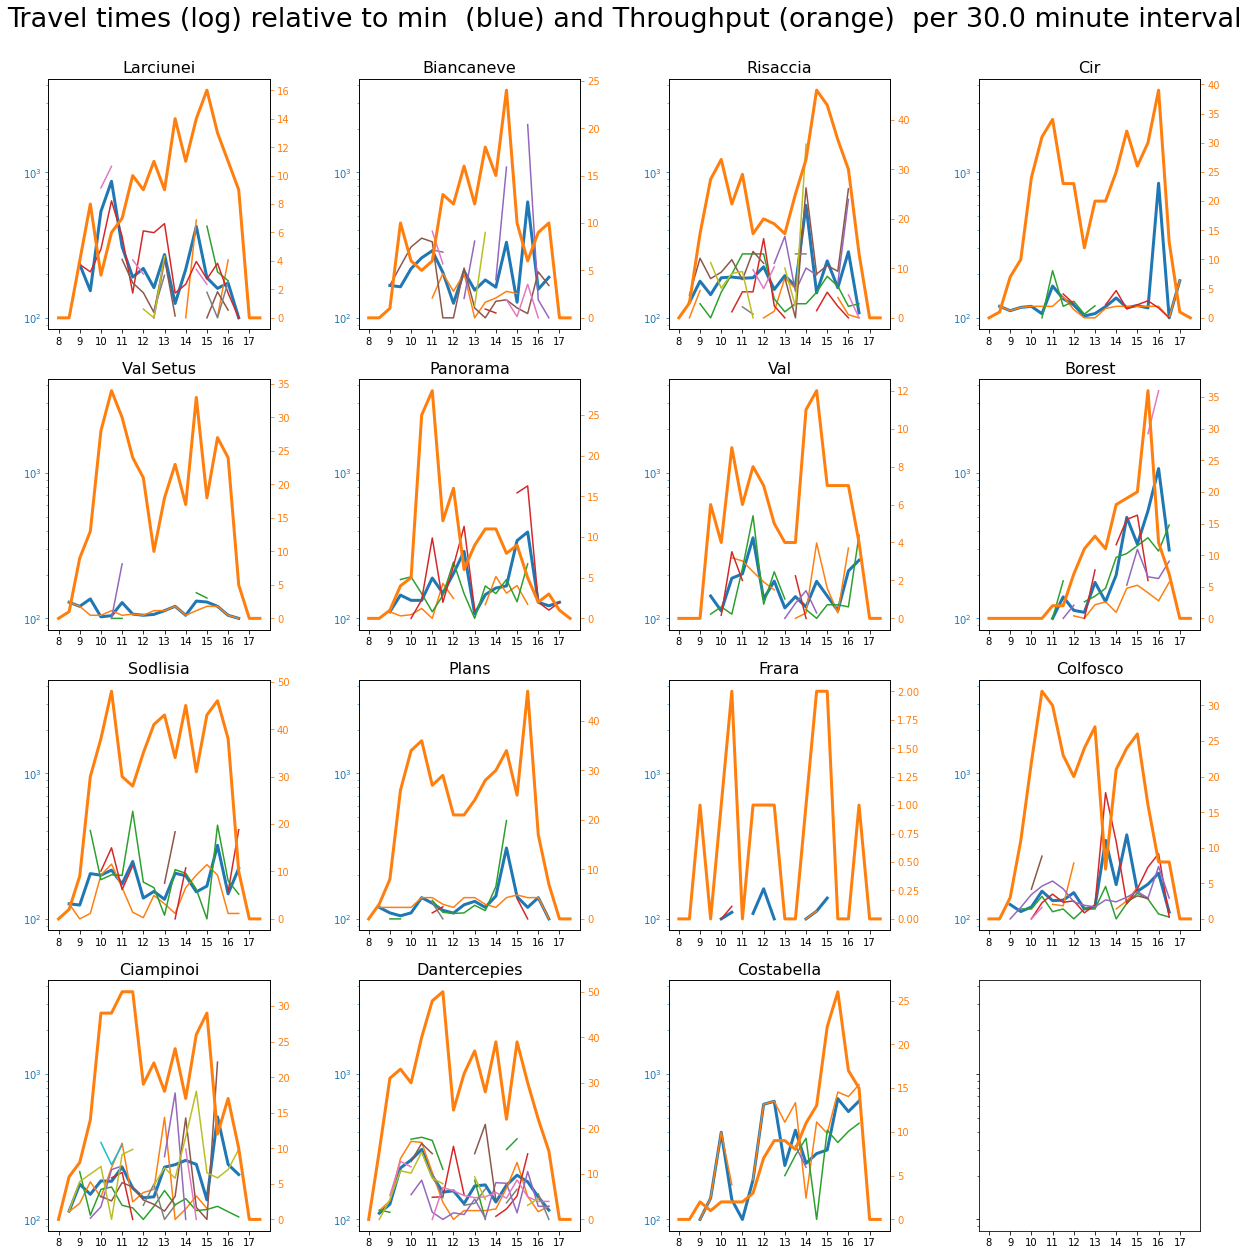

In [84]:
tt.plot(raw=True)

In [ ]:
a = pd.DataFrame(columns = [0,1,2])

a.loc[0] = [np.array([]) for _ in a.columns]
arr = a[0].loc[0]
print(type(arr))
arr = np.append(arr, 1)
if len(arr) == 1:
    a[0].loc[0] = [arr]
else:
    a[0].loc[0] = arr

arr = a[0].loc[0]
print(type(arr))
arr = np.append(arr, 1)
if len(arr) == 1:
    a[0].loc[0] = [arr[0]]
else:
    a[0].loc[0] = arr
    arr = a[0].loc[0]

arr = a[0].loc[0]
print(type(arr))
arr = np.append(arr, 1)
if len(arr) == 1:
    a[0].loc[0] = [arr[0]]
else:
    a[0].loc[0] = arr
a[0].loc[0] = 57
a


In [ ]:
flusso.df[:10]

In [ ]:
flussi.impianti_df

In [ ]:
def last_run_before_time(imp_entrances, time):
    '''
    Finds last entrance in IMP_ENTRANCES before TIME.
    
    parameters:
    IMP_ENTRANCES: a dataframe of a specific skiers entrances onto a specific lift
             TIME: the threshold time
             
    returns:
        I: The index of the last entrance in IMP_ENTRANCES before TIME
    DELTA: The time difference between the desired entrance and TIME
    '''
    delta = dt.timedelta(0)
    t = imp_entrances['DATA_ORA'].iloc[0]
    i = 0
    while t < time and i < len(imp_entrances) - 1:
        i+=1
        delta = time - t
        t = imp_entrances['DATA_ORA'].iloc[i]
    return i, delta

def sellar_anti_class(day, inter_ids):
    '''
    Tries to find skiers who are on the anticlockwise sellaronda on day with index DAY, by examining time
    delta between skiers entrances onto Borest and Ciampinoi. Returns number of rides on lifts given by
    INTER_IDS between Borest and Ciampinoi.
    
    parameters:
          DAY: The index of the day to be analyzed in DATASET_LIST
    INTER_IDS: ID_IMPIANTO of the lifts whose intermediate rides should be counted
    
    returns:
    
    '''
    flusso = dataset_list[day]
    df = flusso.df

    delta_arr = np.array([])
    num_danter_arr = np.array([])
    
    inter_counts = {}
    for inter_id in inter_ids:
        inter_counts[inter_id] = np.array([])

    k=0
    for s in flusso.serie_set:
        if k % 1000 == 0:
            print(k, '/', len(flusso.serie_set))
        k+=1

        ski_day = df[df['SERIE'] == s]
        borest = ski_day[ski_day['ID_IMPIANTO'] == 175]
        ciampi = ski_day[ski_day['ID_IMPIANTO'] == 220]
        
        danter = ski_day[ski_day['ID_IMPIANTO'] == 221]
        cir = ski_day[ski_day['ID_IMPIANTO'] == 232]

        if len(borest) == 0 or len(ciampi) == 0:
            continue

        i, delta = last_run_before_time(borest, ciampi['DATA_ORA'].iloc[0])
        last_borest_time = borest['DATA_ORA'].iloc[i]

        if delta == dt.timedelta(0):
            continue

        def num_inter_runs(inter_id):
            inter_all = ski_day[ski_day['ID_IMPIANTO'] == inter]
            inter_lower = inter_all[inter_all['DATA_ORA'] > last_borest_time]
            inter = inter_lower[inter_lower['DATA_ORA'] < ciampi['DATA_ORA'].iloc[0]]
            return inter
        
        for inter_id in inter_ids:
            ic_arr = inter_counts[inter_id]
            ic_arr = np.append(ic_arr, num_inter_runs(inter_id))

        delta = delta.total_seconds()//60

        delta_arr = np.append(delta_arr, delta)
        
        return delta_arr, 

In [ ]:
plt.hist(num_danter_arr[num_danter_arr>0])
plt.show()

In [ ]:
flusso = dataset_list[6]
df = flusso.df
df['DATA_ORA'][0] - df['DATA_ORA'][120449] > dt.timedelta(0)

In [ ]:
def create_date_range(date_times, is_set = False):
    '''
    parameters:
    DATE_TIMES: Series or set of datetimes
    IS_SET: set to True if DATE_TIMES is a set
    
    return value: a list of datetimes ranging from 
    the earliest to the latest time in DATE_TIMES
    with frequency of one minute
    '''
    if not is_set:
        dt_set = set(date_times)
    else:
        dt_set = date_times
    return pd.date_range(min(dt_set), max(dt_set), freq = 'T')

def skier_path_matrix(flusso, num_skiers = None):
    #TEMP:
    #day_frame = day_frame[day_frame['SERIE'] == 33022]
    day_frame = flusso.df
    if num_skiers:
        day_frame = flusso.df[flusso.df['SERIE'] == random.sample(flusso.serie_set, num_skiers)]
    
    serie = day_frame['SERIE']
    serie_set = list(set(serie))
    data_ora = day_frame['DATA_ORA']
    data_ora_set = set(data_ora)
    impianti = day_frame['ID_IMPIANTO']
    
    dr = create_date_range(data_ora_set, is_set = True)
    
    matrix = pd.DataFrame(columns = dr)
    matrix_norm = pd.DataFrame(columns = np.arange(len(dr)))
    
    k = 0
    max_day = 0
    for skier in serie_set:
        k+=1
        if k%1000 == 0:
            print(f'{k}/{len(serie_set)}')
        ski_day = day_frame[serie == skier].sort_values('DATA_ORA')
        ski_day_ore = ski_day['DATA_ORA']
        
        #print(ski_day)
        
        td_init = int((ski_day_ore.iloc[0] - dr[0]).total_seconds()/60)
        impianti_skier = np.array(np.zeros(td_init))
            
        i=-1
        day_len = 0
        for i in range(len(ski_day) - 1):
            td = int((ski_day_ore.iloc[i+1] - ski_day_ore.iloc[i]).total_seconds()/60)
            to_add = np.full(shape = td, fill_value = ski_day['ID_IMPIANTO'].iloc[i])
            impianti_skier = np.append(impianti_skier, to_add)
            
            day_len += td
        
        if day_len > max_day:
            max_day = day_len
            max_skier = skier
        
        #print(f'len diff: {len(dr) - len(impianti_skier)}, i: {i}, skier: {skier}')
        
        impianti_skier_norm = impianti_skier[td_init:]
        
        fv = ski_day['ID_IMPIANTO'].iloc[i+1]
        fill_norm = np.full(shape = len(dr) - len(impianti_skier_norm), fill_value = fv)
        fill = fill_norm[td_init:]
        
        impianti_skier_norm = np.append(impianti_skier_norm, fill_norm)
        #print(len(impianti_skier_norm), impianti_skier_norm)
        impianti_skier = np.append(impianti_skier, fill)

        matrix.loc[skier] = impianti_skier
        matrix_norm.loc[skier] = impianti_skier_norm
        
    return matrix, matrix_norm

In [ ]:
def skier_path_matrix_latlong(day_frame, num_skiers):
    day_frame = flusso.df
    if num_skiers:
        day_frame = flusso.df[flusso.df['SERIE'].isin(random.sample(flusso.serie_set, num_skiers))]
    
    serie = day_frame['SERIE']
    serie_set = list(set(serie))
    data_ora = day_frame['DATA_ORA']
    data_ora_set = set(data_ora)
    impianti = day_frame['ID_IMPIANTO']
    
    dr = create_date_range(data_ora_set, is_set = True)
    
    matrix = pd.DataFrame(columns = [dr,dr])
    #matrix_norm = pd.DataFrame(columns = np.arange(len(dr)))
    
    k = 0
    max_day = 0
    for skier in serie_set:
        print(skier)
    return matrix
        

In [ ]:
skier_path_matrix_latlong(dataset_list[6].df, 100)

In [ ]:
x = skier_path_matrix(dataset_list[6].df, 100)[0]

In [ ]:
spm = x
a,b=0,0
for i in spm.iterrows():
    for j in spm.iterrows():
        dist = 0
        for k in range(len(i[1])):
            i_pos = get_pos(i[1].iloc[k])
            j_pos = get_pos(j[1].iloc[k])
            dist += get_dist(i_pos, j_pos)
                

In [ ]:
flusso = dataset_list[6]

dat = flusso.df[flusso.df['SERIE'].isin(random.sample(flusso.serie_set, 5))]
dat.sort_values('SERIE')

In [ ]:
a=[i for i in [1,2,3] if i in [1,2]]


a

In [ ]:
next(flusso.df.iterrows())[1]['SERIE']